# Contents:

1. Analyse point clouds, taking **ground detection** as an example
2. Introduce **organised point cloud**

## 1. Coordinate System

In [1]:
# imports
import numpy as np
import open3d as o3d

import imageio.v3 as iio
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
# Read point cloud
pcd = o3d.io.read_point_cloud("./data/depth_2_pcd.ply")

# Create a 3D coordinate system
origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)

# geometries to draw
geometries = [pcd, origin]

# visualize
o3d.visualization.draw_geometries(geometries)

The blue, the red and the green arrows represent the Z-axis, the X-axis and the Y-axis respectively

In [5]:
# Get max and min x,y,z coordinates of the point cloud
x_max = max(pcd.points, key=lambda x:x[0])
y_max = max(pcd.points, key=lambda x:x[1])
z_max = max(pcd.points, key=lambda x:x[2])
x_min = min(pcd.points, key=lambda x:x[0])
y_min = min(pcd.points, key=lambda x:x[1])
z_min = min(pcd.points, key=lambda x:x[2])

In [6]:
# Colors
RED = [1., 0., 0.]
GREEN = [0., 1., 0.]
BLUE = [0., 0., 1.]
YELLOW = [1., 1., 0.]
MAGENTA = [1., 0., 1.]
CYAN = [1., 1., 1.]

positions = [x_max, y_max, z_max, x_min, y_min, z_min]
colors = [RED, GREEN, BLUE, YELLOW, MAGENTA, CYAN]

for i in range(len(positions)):
    # create a sphere mesh
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.05)

    # move to the point position
    sphere.translate(np.asarray(positions[i]))

    # add color
    sphere.paint_uniform_color(np.asarray(colors[i]))

    # compute normals for vertices or faces
    sphere.compute_vertex_normals()

    # add to geometry list to display later
    geometries.append(sphere)

o3d.visualization.draw_geometries(geometries)

## 2. Ground Detection

In the previous plot you'll notice y_max (green sphere) is located on the ground. To detect the ground, we can mark all those points as ground whose y-coordinate is within a certain thresold of y_max.

In [7]:
# Define a threshold
THRESHOLD = 0.1

# Get y-max
y_max = max(pcd.points, key=lambda x:x[1])[1]

# get the original points color to be updated:
pcd_colors = np.asarray(pcd.colors)

# Number of points:
n_points = pcd_colors.shape[0]

# update color:
for i in range(n_points):
    
    if pcd.points[i][1] >= y_max - THRESHOLD:
        pcd_colors[i] = GREEN

pcd.colors = o3d.utility.Vector3dVector(pcd_colors)

o3d.visualization.draw_geometries([pcd, origin])

In real-world applications, the ground is extracted to define the walkable area like in robotics or visually impaired systems or to put objects on it like in interior design systems. It can also be removed, so the remaining points can be segmented or classified like in scene understanding and object detection systems.

## 3. Organised Point Cloud

- An organized point cloud is a 3D pcd data structure that's organized in a 2D array (ordered set), similar to an image with data split into rows and columns.
- Unlike unorganized point clouds, which are simply lists of 3D coordinates, organized point clouds preserve spattial relationships between points
- The organized structure allows for easy access to neighboring points based on their spatial location, as the 2D array mirrors the spatial layout of the points. 

In [8]:
# Creating an organized point cloud from the depth image

# Camera parameters:
FX_DEPTH = 5.8262448167737955e+02
FY_DEPTH = 5.8269103270988637e+02
CX_DEPTH = 3.1304475870804731e+02
CY_DEPTH = 2.3844389626620386e+02

# Read depth image (previously saved grayscale image)
depth_image = iio.imread('./data/depth_2.png')

# Compute the grayscale image:
depth_grayscale = np.array(depth_image / 0x0FFF * 255, dtype=np.uint8)
# Convert a grayscale image to a 3-channel image:
depth_grayscale = np.stack((depth_grayscale,) * 3, axis=-1)

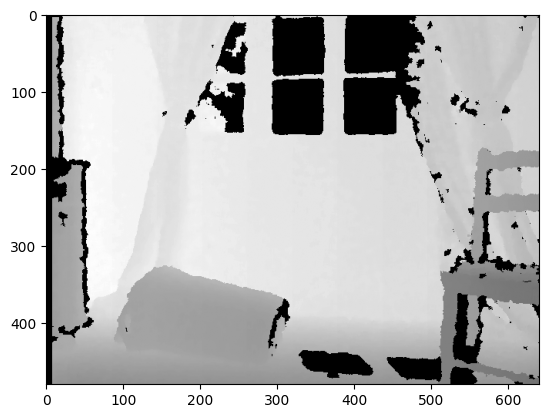

In [9]:
plt.imshow(depth_grayscale[:,:,0], cmap = 'gray')

In [10]:
# get depth image resolution:
h, w = depth_image.shape[:2]
# compute indices and reshape it to have the same shape as the depth image:
jj = np.tile(range(w), h).reshape((h, w))
ii = np.repeat(range(h), w).reshape((h, w))
# Compute constants:
xx = (jj - CX_DEPTH) / FX_DEPTH
yy = (ii - CY_DEPTH) / FY_DEPTH
# compute organised point cloud:
organized_pcd = np.dstack((xx * depth_image, yy * depth_image, depth_image))

print(organized_pcd.shape)

(480, 640, 3)


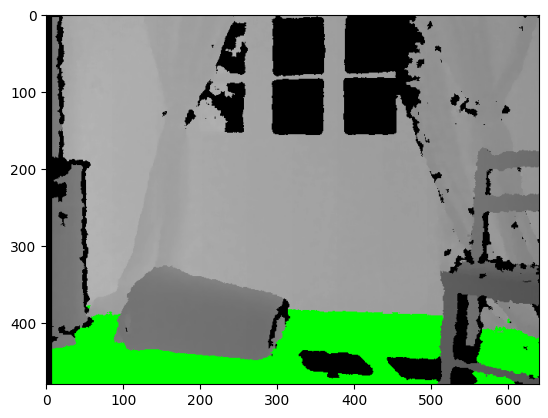

In [87]:
# Ground_detection:
THRESHOLD = 0.075 * 1000  # Define a threshold
y_max = max(organized_pcd.reshape((h * w, 3)), key=lambda x: x[1])[
    1]  # Get the max value along the y-axis

# Set the ground pixels to green:
for i in range(h):
    for j in range(w):
        if organized_pcd[i][j][1] >= y_max - THRESHOLD:
            depth_grayscale[i][j] = [0, 255, 0]  # Update the depth image

# Display depth_grayscale:
plt.imshow(depth_grayscale)
plt.show()